In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Conv3x3:
    
    def __init__(self, num_filters):
        self.num_filters = num_filters
        # для простоты здесь фиксированный размер фильтра 3х3
        # веса (фильтры) задаются случайно из нормального распределения
        self.filters = np.random.randn(num_filters, 3, 3) / 9
        
    def iterate_regions(self, image):
        # image - 2d массив
        h, w = image.shape
        
        # здесь также учтено, что размер фильтра 3х3
        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3)]
                yield im_region, i, j
                
    def forward(self, input_im):
        # принимает 2d массив
        # проход через свёрточный слой
        # возвращает 3d массив (h, w, num_filters)
        
        self.last_input = input_im
        
        h, w = input_im.shape
        output = np.zeros((h - 2, w - 2, self.num_filters))
        
        for im_region, i, j in self.iterate_regions(input_im):
            output[i, j] = np.sum(im_region * self.filters, axis=(1,2))
            
        return output
    
    def backprop(self, d_L_d_out, learn_rate):
        d_L_d_filters = np.zeros(self.filters.shape)
        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region
        # Update filters
        self.filters -= learn_rate * d_L_d_filters
        return None

In [3]:
class MaxPool2:
    
    def iterate_regions(self, image):
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2
        
        # проходим окном 2х2
        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i*2):(i*2 + 2), (j*2):(j*2 + 2)]
                yield im_region, i, j
                
    def forward(self, input_im):
        # принимает 3d массив
        # возвращает 3d массив (h, w, num_filters)
        
        self.last_input = input_im
        
        h, w, num_filters = input_im.shape
        output = np.zeros((h // 2, w // 2, num_filters))
        
        for im_region, i, j in self.iterate_regions(input_im):
            output[i, j] = np.amax(im_region, axis=(0,1))
            
        return output
    
    def backprop(self, d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)
        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))
            
            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        # If this pixel was the max value, copy the gradient to it.
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

In [4]:
class Softmax:
    
    def __init__(self, input_len, neurons):
        self.weights = np.random.randn(input_len, neurons) / input_len
        self.biases = np.zeros(neurons)
        
    def forward(self, input_im):
        # возвращает 1d массив, содержащий вероятности каждого класса
        self.last_input_shape = input_im.shape
        
        input_im = input_im.flatten()
        self.last_input = input_im
        
        input_len, neurons = self.weights.shape
        
        totals = np.dot(input_im, self.weights) + self.biases
        self.last_totals = totals
        
        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)
    
    def backprop(self, d_L_d_out, learn_rate):
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

            # e^totals
            t_exp = np.exp(self.last_totals)

            # Sum of all e^totals
            S = np.sum(t_exp)

            # Gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            # Gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            # Gradients of loss against totals
            d_L_d_t = gradient * d_out_d_t

            # Gradients of loss against weights/biases/input
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

            # Update weights / biases
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b
            return d_L_d_inputs.reshape(self.last_input_shape)

In [5]:
np.random.randn(3, 3, 3) / 9

array([[[ 0.02762667,  0.00038796,  0.0858254 ],
        [ 0.01223377, -0.05423361,  0.13658151],
        [-0.01847857, -0.00847537, -0.02717463]],

       [[ 0.10171143, -0.17760547,  0.11768199],
        [ 0.10598065, -0.20430087,  0.03510829],
        [ 0.06125084,  0.06832674,  0.0739721 ]],

       [[-0.08876209, -0.08403359, -0.08609328],
        [-0.16191775, -0.13529041, -0.17774089],
        [-0.0261523 ,  0.10716447,  0.07161329]]])

In [6]:
image = np.array([
    [0, 50, 0, 29],
    [0, 80, 31, 2],
    [33, 90, 0, 75],
    [0, 9, 0, 95],
])

In [7]:
my_filter = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])
my_filter = my_filter.reshape(1, 3, 3)

In [8]:
conv_layer = Conv3x3(1)
conv_layer.filters = my_filter
conv_layer.forward(image)

array([[[  29.],
        [-192.]],

       [[ -35.],
        [ -22.]]])

In [9]:
# !pip install mnist

In [10]:
import mnist

In [11]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [12]:
conv = Conv3x3(8)
output = conv.forward(train_images[0])
print(output.shape)

(26, 26, 8)


In [13]:
pool = MaxPool2()
pool.forward(output).shape

(13, 13, 8)

In [14]:
softmax = Softmax(13*13*8, 10) # 10 классов цифр

In [15]:
softmax.forward(pool.forward(output))

array([0.08669604, 0.03231991, 0.07605854, 0.12974527, 0.22147677,
       0.05328741, 0.05463816, 0.0701054 , 0.04547035, 0.23020214])

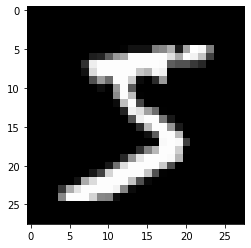

In [16]:
plt.imshow(train_images[0], cmap='gray')

Пример вертикального фильтра Собеля

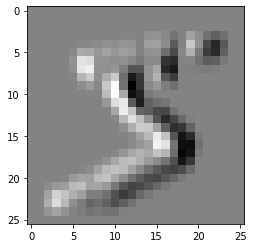

In [17]:
plt.imshow(conv_layer.forward(train_images[0]).reshape(26,26), cmap='gray')

Пример горизонтального фильтра Собеля

In [20]:
my_filter = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
]).T
my_filter = my_filter.reshape(1, 3, 3)

In [21]:
conv_layer = Conv3x3(1)
conv_layer.filters = my_filter
conv_layer.forward(image)

array([[[ 113.],
        [  86.]],

       [[-173.],
        [ -40.]]])

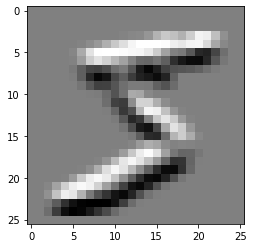

In [22]:
plt.imshow(conv_layer.forward(train_images[0]).reshape(26,26), cmap='gray')

Просто выделение границ

In [23]:
my_filter = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0],
])
my_filter = my_filter.reshape(1, 3, 3)

In [24]:
conv_layer = Conv3x3(1)
conv_layer.filters = my_filter
conv_layer.forward(image)

array([[[-149.],
        [ -42.]],

       [[-238.],
        [ 196.]]])

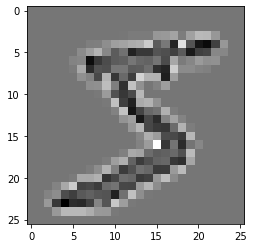

In [25]:
plt.imshow(conv_layer.forward(train_images[0]).reshape(26,26), cmap='gray')

### Нейросеть с обучением для классификации

In [26]:
def mnist_preprocessing(image, label, lr=0.005):
    out = conv.forward((image / 255) - 0.5)
    out = pool.forward(out)
    
    out = softmax.forward(out)
    
    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]
    
    gradient = softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)
    
    loss = -np.log(out[label])
    acc = 1 if np.argmax(out) == label else 0
    
    return out, loss, acc

In [27]:
test_images = mnist.test_images()[:1000]
test_labels = mnist.test_labels()[:1000]

In [28]:
permutation = np.random.permutation(len(train_images))
train_images = train_images[permutation]
train_labels = train_labels[permutation]

In [29]:
%%time
loss = 0
num_correct = 0
for i, (im, label) in enumerate(zip(test_images, test_labels)):
  # Do a forward pass.
    _, l, acc = mnist_preprocessing(im, label)
    loss += l
    num_correct += acc
    
    if (i+1) % 100 == 0:
        print(
            '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
            (i + 1, loss / 100, num_correct)
        )
        loss = 0
        num_correct = 0

[Step 100] Past 100 steps: Average Loss 2.204 | Accuracy: 20%
[Step 200] Past 100 steps: Average Loss 1.939 | Accuracy: 39%
[Step 300] Past 100 steps: Average Loss 1.381 | Accuracy: 54%
[Step 400] Past 100 steps: Average Loss 1.181 | Accuracy: 60%
[Step 500] Past 100 steps: Average Loss 0.961 | Accuracy: 69%
[Step 600] Past 100 steps: Average Loss 0.971 | Accuracy: 63%
[Step 700] Past 100 steps: Average Loss 0.886 | Accuracy: 69%
[Step 800] Past 100 steps: Average Loss 0.563 | Accuracy: 81%
[Step 900] Past 100 steps: Average Loss 0.461 | Accuracy: 88%
[Step 1000] Past 100 steps: Average Loss 0.649 | Accuracy: 77%
CPU times: user 2min 42s, sys: 5min 41s, total: 8min 24s
Wall time: 1min 4s


In [30]:
def forward(image, label):
    '''
    Completes a forward pass of the CNN and calculates the accuracy and
    cross-entropy loss.
    - image is a 2d numpy array
    - label is a digit
    '''
    # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
    # to work with. This is standard practice.
    out = conv.forward((image / 255) - 0.5)
    out = pool.forward(out)
    out = softmax.forward(out)

    # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
    loss = -np.log(out[label])
    acc = 1 if np.argmax(out) == label else 0

    return out, loss, acc

In [31]:
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
    _, l, acc = forward(im, label)
    loss += l
    num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


--- Testing the CNN ---
Test Loss: 0.5420497326083827
Test Accuracy: 0.814
